## Random Forest Classifier

Objectif : améliorer le *model scoring*. 

Une fois que le modèle est entrainé (avec sklearn par exemple), on souhaite faire des prédictions (ou une seule par intervalle).

Avec un dummy dataset, l'appel à la fonction ``clf.predict`` est de l'ordre de la milliseconde. Peut-on faire mieux ?

### Baseline

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.tree import plot_tree

import matplotlib.pyplot as plt
import numpy as np

In [2]:
X, y = make_classification(n_samples=1000, n_features=4,
                           n_informative=2, n_redundant=0,
                           random_state=0, shuffle=False)

In [3]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, y)

RandomForestClassifier(max_depth=2, random_state=0)

In [4]:
print(clf.predict([[0, 0, 0, 0]]))

[1]


In [5]:
%timeit clf.predict([[0, 0, 0, 0]])

7.9 ms ± 290 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

Accès à la liste des arbres

In [7]:
clf.estimators_[:3]

[DecisionTreeClassifier(max_depth=2, max_features='auto', random_state=209652396),
 DecisionTreeClassifier(max_depth=2, max_features='auto', random_state=398764591),
 DecisionTreeClassifier(max_depth=2, max_features='auto', random_state=924231285)]

In [8]:
tree = clf.estimators_[0]

## [Understanding the decision tree structure](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py)

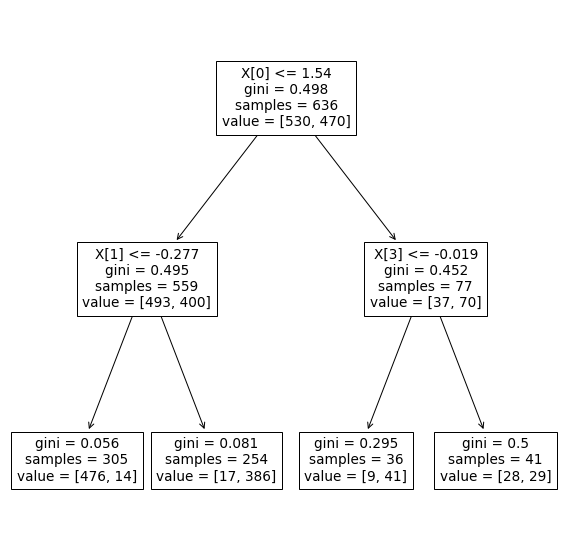

In [9]:
plt.figure(figsize=(10,10))
plot_tree(tree);

In [10]:
tree.tree_.children_left

array([ 1,  2, -1, -1,  5, -1, -1])

In [11]:
tree.tree_.children_right

array([ 4,  3, -1, -1,  6, -1, -1])

In [12]:
tree.tree_.feature

array([ 0,  1, -2, -2,  3, -2, -2])

In [13]:
tree.tree_.threshold

array([ 1.53954744, -0.27732854, -2.        , -2.        , -0.01899489,
       -2.        , -2.        ])

In [14]:
tree.tree_.value

array([[[530., 470.]],

       [[493., 400.]],

       [[476.,  14.]],

       [[ 17., 386.]],

       [[ 37.,  70.]],

       [[  9.,  41.]],

       [[ 28.,  29.]]])

In [15]:
tree.tree_.threshold

array([ 1.53954744, -0.27732854, -2.        , -2.        , -0.01899489,
       -2.        , -2.        ])

### Stratégie GEMM (GEneric Matrix Multiplication)

In [16]:
def get_internal_and_leaf_nodes(tree):
    is_internal_nodes = tree.tree_.children_left != tree.tree_.children_right
    return np.flatnonzero(is_internal_nodes), np.flatnonzero(~is_internal_nodes)

In [17]:
internal_nodes, leaf_nodes = get_internal_and_leaf_nodes(tree)

In [18]:
internal_nodes, leaf_nodes

(array([0, 1, 4]), array([2, 3, 5, 6]))

In [19]:
sub_to_global_internal_nodes = { v:k for k,v in enumerate(internal_nodes) }

In [20]:
s_to_g = lambda x : sub_to_global_internal_nodes[x]

In [22]:
split_features_internal_nodes = tree.tree_.feature[internal_nodes]
split_features_internal_nodes

array([0, 1, 3])

#### Matrice A

In [23]:
A = np.zeros(shape=(X.shape[1], len(internal_nodes)))
for i,j in enumerate(split_features_internal_nodes):
    A[j,i] = 1
A

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.],
       [0., 0., 1.]])

#### Matrice B

In [24]:
B = tree.tree_.threshold[internal_nodes]
B

array([ 1.53954744, -0.27732854, -0.01899489])

#### Matrice C

In [25]:
C = np.zeros(shape=(len(internal_nodes), len(leaf_nodes)))
D = np.zeros(tree.tree_.n_leaves)
C,D

(array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([0., 0., 0., 0.]))

In [26]:
def compute_path(tree, k):
    """Compute path from nodes (leaf or internal) to root.
    Args:
        tree
        k (int) : index from start
    Return:
        List of [id, 1] if LeftSubTree, [id, -1] if RightSubTree
    """
    l = [[k,0]]
    left = tree.tree_.children_left
    right = tree.tree_.children_right

    while l[-1][0] != 0:
        parent_left = np.flatnonzero((left == l[-1][0]),)
        parent_right = np.flatnonzero((right == l[-1][0]),)

        if len(parent_left) > 0:
            l.append([parent_left[0], 1])
        else:
            l.append([parent_right[0], -1])

    return l[1:]

In [27]:
leaf_nodes

array([2, 3, 5, 6])

In [28]:
internal_nodes

array([0, 1, 4])

In [29]:
compute_path(tree, 5)

[[4, 1], [0, -1]]

In [30]:
for j, leaf_idx in enumerate(leaf_nodes):
    path = compute_path(tree, leaf_idx)

    for i in range(len(path)):
        path[i][0] = s_to_g(path[i][0])
    
    for node_idx, value in path:
        C[node_idx,j] = value

In [31]:
path

[[2, -1], [0, -1]]

In [32]:
C

array([[ 1.,  1., -1., -1.],
       [ 1., -1.,  0.,  0.],
       [ 0.,  0.,  1., -1.]])

#### Matrice D

In [33]:
D = np.sum(C == 1, axis=0)
D

array([2, 1, 1, 0])

#### Matrice E

In [34]:
E = np.zeros(shape=(tree.tree_.n_leaves, tree.n_classes_), dtype=int)
leaf_to_class = tree.tree_.value[leaf_nodes].argmax(axis=-1).flatten()

for i in range(len(leaf_nodes)):
    E[i,leaf_to_class[i]] = 1
E

array([[1, 0],
       [0, 1],
       [0, 1],
       [0, 1]])

### Vérifions que tout fonctionne

In [35]:
%timeit y_true = tree.tree_.predict(X.astype(np.float32))

14.3 µs ± 343 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [37]:
y_true = tree.tree_.predict(X.astype(np.float32))

In [38]:
y_true

array([[476.,  14.],
       [476.,  14.],
       [476.,  14.],
       ...,
       [ 17., 386.],
       [ 17., 386.],
       [ 17., 386.]])

In [39]:
def GEMM_strategy(X):
    T = X.dot(A)
    T = T < B
    T = T.dot(C)
    T = T == D
    return T.dot(E)

In [40]:
from numba import njit

In [41]:
@njit
def numba_GEMM_strategy(X):
    T = X.dot(A)
    T = (T < B)
    T = T.astype(np.float64)
    T = T.dot(C)
    T = T.astype(np.int64)
    T = T == D
    T = T.astype(np.float64)
    T = T.dot(E.astype(np.float64))
    return T

In [42]:
(y_true == y_true.max(axis=1)[:,None]).astype(int)

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [43]:
np.all((y_true == y_true.max(axis=1)[:,None]).astype(int) == GEMM_strategy(X))

True

In [44]:
%timeit GEMM_strategy(X)

53 µs ± 1.76 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [46]:
%timeit numba_GEMM_strategy(X)

32.4 µs ± 128 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
